# Flight Price Predictor Project

**Authors:** Emily Xiaoqi He, Huijing Yang, Lokendra Singh Badgujar, Sheng Zhou and Karollyne Zortea (Team Lead)

# Problem Statement

Air travel is an essential aspect of modern life, with millions of people relying on it for business, leisure, and personal connections. The fluctuating nature of flight prices, influenced by factors such as supply, demand, seasonality, and competition, often leaves travelers overwhelmed when trying to find the best deals on airfare. At the same time, airlines and travel companies are constantly seeking to optimize their pricing strategies to maximize revenues and maintain customer satisfaction. Despite the abundance of flight data available, accurately forecasting flight prices remains a challenge for both travelers and industry stakeholders. Our goal is to develop a flight price predictor that leverages big data techniques and machine learning algorithms to accurately forecast flight prices, enabling travelers to make informed decisions and save money on air travel. By providing essential information, such as departure date and time, arrival time, source and destination, number of stops, and airline name, our solution aims to empower users with the insights they need while also assisting airlines and travel companies in refining their pricing strategies.

# Flight Prices Dataset

**Data source:** https://www.kaggle.com/datasets/dilwong/flightprices

**About the dataset:** Each row of this dataset is a purchasable ticket found on Expedia between 2022-04-16 and 2022-10-05, to/from the following airports: ATL, DFW, DEN, ORD, LAX, CLT, MIA, JFK, EWR, SFO, DTW, BOS, PHL, LGA, IAD, OAK.

**Columns in this Dataset:**


|Column Name|Description|Type|
|--|--|--|
|legId|An identifier for the flight.|String|
|searchDate|The date on which this entry was taken from Expedia.|Timestamp|
|flightDate|The date of the flight.|Timestamp|
|startingAirport|Three-character IATA airport code for the initial location.|String|
|destinationAirport|Three-character IATA airport code for the arrival location.|String|
|fareBasisCode|The fare basis code.|String|
|travelDuration|The travel duration in hours and minutes.|String|
|elapsedDays|The number of elapsed days (usually 0).|Integer|
|isBasicEconomy|Indicates whether the ticket is for basic economy.|Boolean|
|isRefundable|Indicates whether the ticket is refundable.|Boolean|
|isNonStop|Indicates whether the flight is non-stop.|Boolean|
|baseFare|The price of the ticket (in USD).|Double|
|totalFare|The price of the ticket (in USD) including taxes and other fees.|Double|
|seatsRemaining|Indicates the number of seats remaining.|Integer|
|totalTravelDistance|The total travel distance in miles.|Integer|
|segmentsDepartureTimeEpochSeconds|Departure time for each leg of the trip, provided in Unix time format.|String|
|segmentsDepartureTimeRaw|The departure time for each leg of the trip.|String|
|segmentsArrivalTimeEpochSeconds|The arrival time for each leg of the trip, provided in Unix time format.|String|
|segmentsArrivalTimeRaw|The arrival time for each leg of the trip.|String|
|segmentsArrivalAirportCode|The IATA airport code for the arrival location of each leg of the trip.|String|
|segmentsDepartureAirportCode|The IATA airport code for the departure location of each leg of the trip.|String|
|segmentsAirlineName|The name of the airline that services each leg of the trip.|String|
|segmentsAirlineCode|The two-letter airline code that services each leg of the trip.|String|
|segmentsEquipmentDescription|The type of airplane used for each leg of the trip.|String|
|segmentsDurationInSeconds|The duration of the flight (in seconds) for each leg of the trip.|String|
|segmentsDistance|The distance traveled (in miles) for each leg of the trip.|String|
|segmentsCabinCode|The cabin class for each leg of the trip.|String|

### Importing libraries:

In [59]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pyspark.sql.functions import *
from pyspark.sql.functions import desc
import pyspark.pandas as ps
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType,StructField, StringType, IntegerType, DateType, DoubleType, LongType, ArrayType
from pyspark.sql import functions as F
from pyspark.sql.functions import col, sum
from pyspark.sql.functions import to_date
from pyspark.sql.functions import split, substring
from pyspark.sql.functions import expr
from pyspark.sql.functions import regexp_replace, split
from pyspark.sql.functions import skewness
import pyspark.sql.types as T
from pyspark.sql.functions import when, count
from pyspark.sql.functions import month, avg
from pyspark.sql.window import Window
from pyspark.sql.functions import row_number
from pyspark.sql.functions import monotonically_increasing_id
from pyspark.sql.functions import asc

### Loading and Caching into PySpark Dataframe:

In [2]:
spark = SparkSession.builder.getOrCreate()

print(spark)

In [3]:
data = "gs://is843-team2/notebooks/jupyter/"

flight_data = spark.read.format("csv") \
    .option("header", "true") \
    .option("inferSchema", "true") \
    .load(data + "itineraries_data.csv")

In [4]:
flight_data.printSchema()

root
 |-- legId: string (nullable = true)
 |-- searchDate: timestamp (nullable = true)
 |-- flightDate: timestamp (nullable = true)
 |-- startingAirport: string (nullable = true)
 |-- destinationAirport: string (nullable = true)
 |-- fareBasisCode: string (nullable = true)
 |-- travelDuration: string (nullable = true)
 |-- elapsedDays: integer (nullable = true)
 |-- isBasicEconomy: boolean (nullable = true)
 |-- isRefundable: boolean (nullable = true)
 |-- isNonStop: boolean (nullable = true)
 |-- baseFare: double (nullable = true)
 |-- totalFare: double (nullable = true)
 |-- seatsRemaining: integer (nullable = true)
 |-- totalTravelDistance: integer (nullable = true)
 |-- segmentsDepartureTimeEpochSeconds: string (nullable = true)
 |-- segmentsDepartureTimeRaw: string (nullable = true)
 |-- segmentsArrivalTimeEpochSeconds: string (nullable = true)
 |-- segmentsArrivalTimeRaw: string (nullable = true)
 |-- segmentsArrivalAirportCode: string (nullable = true)
 |-- segmentsDepartureAirp

## Basic Exploration and Data Cleaning

In [5]:
flight_data.show(5, False)

23/04/04 17:55:01 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+--------------------------------+-------------------+-------------------+---------------+------------------+-------------+--------------+-----------+--------------+------------+---------+--------+---------+--------------+-------------------+---------------------------------+-----------------------------+-------------------------------+-----------------------------+--------------------------+----------------------------+-------------------+-------------------+----------------------------+-------------------------+----------------+-----------------+
|legId                           |searchDate         |flightDate         |startingAirport|destinationAirport|fareBasisCode|travelDuration|elapsedDays|isBasicEconomy|isRefundable|isNonStop|baseFare|totalFare|seatsRemaining|totalTravelDistance|segmentsDepartureTimeEpochSeconds|segmentsDepartureTimeRaw     |segmentsArrivalTimeEpochSeconds|segmentsArrivalTimeRaw       |segmentsArrivalAirportCode|segmentsDepartureAirportCode|segmentsAirlineName|s

In [8]:
# Getting the number of records

print("The data contain %d records." % flight_data.count())

The data contain 82138753 records.


In [9]:
# Counting/Checking for null values

flight_data.select([F.count(F.when(F.col(c).isNull(), c)).alias(c) for c in flight_data.columns]).toPandas().transpose()

,0
legId,0
searchDate,0
flightDate,0
startingAirport,0
destinationAirport,0
fareBasisCode,0
travelDuration,0
elapsedDays,0
isBasicEconomy,0
isRefundable,0


As we see from the results above, we have **6094532** missing values for **'totalTravelDistance'** and **1557592** for **'segmentsEquipmentDescription'**

We will leave **'totalTravelDistance'** as it is for now.
We will be dropping **'segmentsEquipmentDescription'** among other columns as they are not relevant in predicting flight prices.

In [4]:
# Dropping the following columns as they will not be used in the prediction of flight prices

flight_data = flight_data.drop('searchDate', 'segmentsDepartureTimeEpochSeconds', 'segmentsArrivalTimeEpochSeconds', 'fareBasicCode', 
                               'segmentsCabinCode', 'legId', 'elapsedDays', 'segmentsEquipmentDescription', 'segmentsArrivalAirportCode', 
                               'segmentsDepartureAirportCode', 'segmentsAirlineCode', 'fareBasisCode')

In [5]:
flight_data.columns

['flightDate',
 'startingAirport',
 'destinationAirport',
 'travelDuration',
 'isBasicEconomy',
 'isRefundable',
 'isNonStop',
 'baseFare',
 'totalFare',
 'seatsRemaining',
 'totalTravelDistance',
 'segmentsDepartureTimeRaw',
 'segmentsArrivalTimeRaw',
 'segmentsAirlineName',
 'segmentsDurationInSeconds',
 'segmentsDistance']

In [6]:
flight_data.dtypes

[('flightDate', 'timestamp'),
 ('startingAirport', 'string'),
 ('destinationAirport', 'string'),
 ('travelDuration', 'string'),
 ('isBasicEconomy', 'boolean'),
 ('isRefundable', 'boolean'),
 ('isNonStop', 'boolean'),
 ('baseFare', 'double'),
 ('totalFare', 'double'),
 ('seatsRemaining', 'int'),
 ('totalTravelDistance', 'int'),
 ('segmentsDepartureTimeRaw', 'string'),
 ('segmentsArrivalTimeRaw', 'string'),
 ('segmentsAirlineName', 'string'),
 ('segmentsDurationInSeconds', 'string'),
 ('segmentsDistance', 'string')]

In [8]:
flight_data.select('flightDate').show(5)

+-------------------+
|         flightDate|
+-------------------+
|2022-04-17 00:00:00|
|2022-04-17 00:00:00|
|2022-04-17 00:00:00|
|2022-04-17 00:00:00|
|2022-04-17 00:00:00|
+-------------------+
only showing top 5 rows



In [7]:
# 'flightDate' is in timestamp format, converting into date format

flight_data = flight_data.withColumn('flightDate', to_date('flightDate'))

In [8]:
flight_data.select('flightDate').show(5)

+----------+
|flightDate|
+----------+
|2022-04-17|
|2022-04-17|
|2022-04-17|
|2022-04-17|
|2022-04-17|
+----------+
only showing top 5 rows



In [9]:
flight_data.select('segmentsDepartureTimeRaw').show(5)

+------------------------+
|segmentsDepartureTimeRaw|
+------------------------+
|    2022-04-17T12:57:...|
|    2022-04-17T06:30:...|
|    2022-04-17T11:35:...|
|    2022-04-17T13:59:...|
|    2022-04-17T09:59:...|
+------------------------+
only showing top 5 rows



In [10]:
flight_data.select('segmentsArrivalTimeRaw').show(5)

+----------------------+
|segmentsArrivalTimeRaw|
+----------------------+
|  2022-04-17T15:26:...|
|  2022-04-17T09:00:...|
|  2022-04-17T14:05:...|
|  2022-04-17T16:31:...|
|  2022-04-17T12:33:...|
+----------------------+
only showing top 5 rows



The columns **'segmentsDepartureTimeRaw'** and **'segmentsArrivalTimeRaw'** contain the complete timestamp information for the departure and arrival times, including year, month, day, hour, minute, second, and milliseconds in a single string. 

We will be splitting these strings, extracting the date and time components to create two new columns and dropping the original columns **'segmentsDepartureTimeRaw'** and **'segmentsArrivalTimeRaw'**.

In [11]:
flight_data = flight_data.withColumn('segmentsDepartureDate', split('segmentsDepartureTimeRaw', 'T').getItem(0))
flight_data = flight_data.withColumn('segmentsDepartureTime', substring('segmentsDepartureTimeRaw', 12, 8))

flight_data = flight_data.drop('segmentsDepartureTimeRaw')

In [12]:
flight_data.select('segmentsDepartureDate', 'segmentsDepartureTime').show(5)

+---------------------+---------------------+
|segmentsDepartureDate|segmentsDepartureTime|
+---------------------+---------------------+
|           2022-04-17|             12:57:00|
|           2022-04-17|             06:30:00|
|           2022-04-17|             11:35:00|
|           2022-04-17|             13:59:00|
|           2022-04-17|             09:59:00|
+---------------------+---------------------+
only showing top 5 rows



In [13]:
flight_data = flight_data.withColumn('segmentsArrivalDate', split('segmentsArrivalTimeRaw', 'T').getItem(0))
flight_data = flight_data.withColumn('segmentsArrivalTime', substring('segmentsArrivalTimeRaw', 12, 8))

flight_data = flight_data.drop('segmentsArrivalTimeRaw')

In [14]:
flight_data.select('segmentsArrivalDate', 'segmentsArrivalTime').show(5)

+-------------------+-------------------+
|segmentsArrivalDate|segmentsArrivalTime|
+-------------------+-------------------+
|         2022-04-17|           15:26:00|
|         2022-04-17|           09:00:00|
|         2022-04-17|           14:05:00|
|         2022-04-17|           16:31:00|
|         2022-04-17|           12:33:00|
+-------------------+-------------------+
only showing top 5 rows



In [15]:
flight_data.columns

['flightDate',
 'startingAirport',
 'destinationAirport',
 'travelDuration',
 'isBasicEconomy',
 'isRefundable',
 'isNonStop',
 'baseFare',
 'totalFare',
 'seatsRemaining',
 'totalTravelDistance',
 'segmentsAirlineName',
 'segmentsDurationInSeconds',
 'segmentsDistance',
 'segmentsDepartureDate',
 'segmentsDepartureTime',
 'segmentsArrivalDate',
 'segmentsArrivalTime']

Renaming some of the columns:

In [16]:
flight_data = flight_data.withColumnRenamed('segmentsAirlineName', 'airline_name') \
    .withColumnRenamed('segmentsDurationInSeconds', 'duration_in_seconds') \
    .withColumnRenamed('segmentsDistance', 'distance') \
    .withColumnRenamed('segmentsDepartureDate', 'departure_date') \
    .withColumnRenamed('segmentsDepartureTime', 'departure_time') \
    .withColumnRenamed('segmentsArrivalDate', 'arrival_date') \
    .withColumnRenamed('segmentsArrivalTime', 'arrival_time')

In [17]:
flight_data.columns

['flightDate',
 'startingAirport',
 'destinationAirport',
 'travelDuration',
 'isBasicEconomy',
 'isRefundable',
 'isNonStop',
 'baseFare',
 'totalFare',
 'seatsRemaining',
 'totalTravelDistance',
 'airline_name',
 'duration_in_seconds',
 'distance',
 'departure_date',
 'departure_time',
 'arrival_date',
 'arrival_time']

In [18]:
flight_data.select('travelDuration').show(5)

+--------------+
|travelDuration|
+--------------+
|       PT2H29M|
|       PT2H30M|
|       PT2H30M|
|       PT2H32M|
|       PT2H34M|
+--------------+
only showing top 5 rows



In [19]:
# Converting travelDuration to hours

flight_data = flight_data.withColumn("travelDuration", regexp_replace("travelDuration", "PT", "")) \
                         .withColumn("travelDuration", regexp_replace("travelDuration", "M", "")) \
                         .withColumn("hours", split("travelDuration", "H").getItem(0).cast("float")) \
                         .withColumn("minutes", split("travelDuration", "H").getItem(1).cast("float")) \
                         .withColumn("total_duration_hours", col("hours") + col("minutes")/60) \
                         .drop("travelDuration", "hours", "minutes")

In [20]:
flight_data.select('total_duration_hours').show(5)

+--------------------+
|total_duration_hours|
+--------------------+
|  2.4833333333333334|
|                 2.5|
|                 2.5|
|   2.533333333333333|
|  2.5666666666666664|
+--------------------+
only showing top 5 rows



In [21]:
# Creating a new column (which is derived from the 'flightDate' column) with name of the week for each corresponding date

flight_data = flight_data.withColumn('flight_week_day', date_format('flightDate', 'EEEE'))

In [22]:
flight_data.columns

['flightDate',
 'startingAirport',
 'destinationAirport',
 'isBasicEconomy',
 'isRefundable',
 'isNonStop',
 'baseFare',
 'totalFare',
 'seatsRemaining',
 'totalTravelDistance',
 'airline_name',
 'duration_in_seconds',
 'distance',
 'departure_date',
 'departure_time',
 'arrival_date',
 'arrival_time',
 'total_duration_hours',
 'flight_week_day']

In [23]:
flight_data.select('flight_week_day').show(5)

+---------------+
|flight_week_day|
+---------------+
|         Sunday|
|         Sunday|
|         Sunday|
|         Sunday|
|         Sunday|
+---------------+
only showing top 5 rows



Since we have already converted **'travelDuration'** to hours and created a new column **'total_duration_hours'**, we will be dropping **'duration_in_seconds'** as it is no longer needed.

In [24]:
flight_data = flight_data.drop('duration_in_seconds')

In [27]:
flight_data.columns

['flightDate',
 'startingAirport',
 'destinationAirport',
 'isBasicEconomy',
 'isRefundable',
 'isNonStop',
 'baseFare',
 'totalFare',
 'seatsRemaining',
 'totalTravelDistance',
 'airline_name',
 'distance',
 'departure_date',
 'departure_time',
 'arrival_date',
 'arrival_time',
 'total_duration_hours',
 'flight_week_day']

Computing basic statistics on **'totalFare'** as it is our **target variable**:

In [28]:
flight_data.select("totalFare").describe().show()

+-------+-----------------+
|summary|        totalFare|
+-------+-----------------+
|  count|         82138753|
|   mean|340.3868491397912|
| stddev|196.0295099117059|
|    min|            19.59|
|    max|          8260.61|
+-------+-----------------+



As shown in the results above:
* The average flight price is **\$340.38**
* The minimum flight price is: **\$19.59**
* The maximum flight price is: **\$8260.61**

Sampling a subset of **flight_data** to reduce its size and to make it easier/faster to work with:

In [29]:
sample_flight_data = flight_data.sample(0.1, seed=50)

In [30]:
sample_flight_data.cache()

DataFrame[flightDate: date, startingAirport: string, destinationAirport: string, isBasicEconomy: boolean, isRefundable: boolean, isNonStop: boolean, baseFare: double, totalFare: double, seatsRemaining: int, totalTravelDistance: int, airline_name: string, distance: string, departure_date: string, departure_time: string, arrival_date: string, arrival_time: string, total_duration_hours: double, flight_week_day: string]

In [32]:
print("The data contain %d records." % sample_flight_data.count())

The data contain 8215684 records.


Calculating skewness of **'totalFare'**:

In [31]:
skew_value = sample_flight_data.select(skewness('totalFare')).collect()[0][0]
print(skew_value)

2.0779324506538077


<AxesSubplot:xlabel='totalFare', ylabel='Count'>

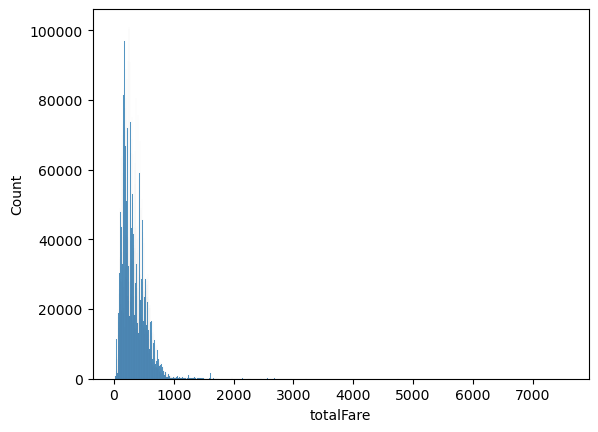

In [33]:
sns.histplot(sample_flight_data.toPandas(), x='totalFare')

As seen from the graph above, total fare is **skewed to the left**, meaning it is not symmetrical and implying that the majority of the values lie on the right side of the mean with a few extreme values towards the left side of the distribuition. 

We will go ahead and check for these extreme values **(outliers)**:

In [ ]:
#sample_flight_data = sample_flight_data.toPandas()

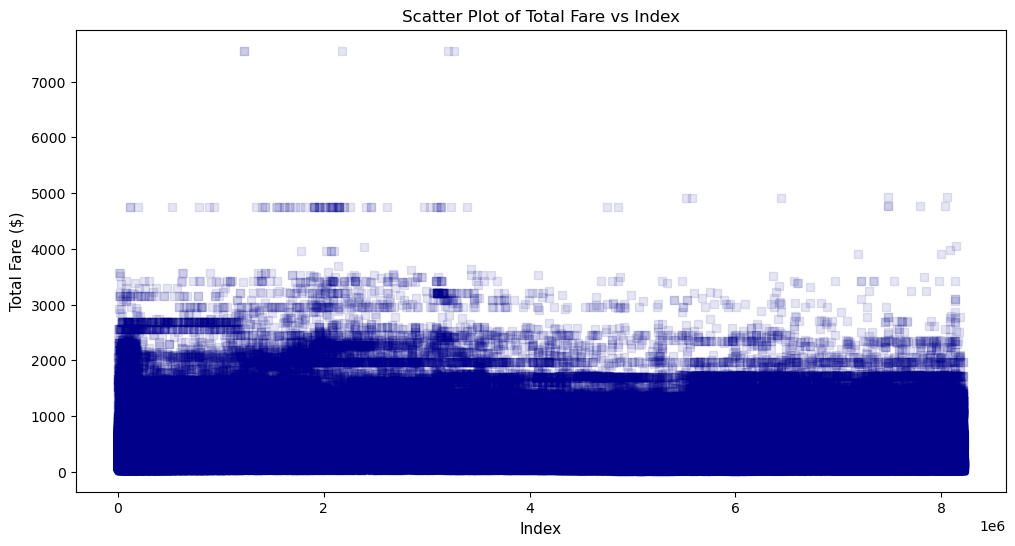

In [29]:
sample_flight_data_pd = sample_flight_data.toPandas()

fig, ax = plt.subplots(figsize=(12, 6))
ax.scatter(x=sample_flight_data_pd.index, y=sample_flight_data_pd['totalFare'], marker='s', color='darkblue', alpha=0.1)

ax.set_xlabel('Index', fontsize=11)
ax.set_ylabel('Total Fare ($)', fontsize=11)
ax.set_title('Scatter Plot of Total Fare vs Index', fontsize=12)

plt.show()

As seen in the plot above, there are a couple of outliers.
We will remove anything above \$6,000:

In [32]:
totalfare_outliers = sample_flight_data.filter(sample_flight_data.totalFare > 6000)
totalfare_outliers.show()

+----------+---------------+------------------+--------------+------------+---------+--------+---------+--------------+-------------------+--------------------+---------+--------------+--------------+------------+------------+--------------------+---------------+
|flightDate|startingAirport|destinationAirport|isBasicEconomy|isRefundable|isNonStop|baseFare|totalFare|seatsRemaining|totalTravelDistance|        airline_name| distance|departure_date|departure_time|arrival_date|arrival_time|total_duration_hours|flight_week_day|
+----------+---------------+------------------+--------------+------------+---------+--------+---------+--------------+-------------------+--------------------+---------+--------------+--------------+------------+------------+--------------------+---------------+
|2022-05-26|            SFO|               DTW|         false|       false|    false|  7000.0|   7548.6|            10|               2606|American Airlines...|679||1927|    2022-05-26|      19:50:00|  2022-0

In [40]:
#sample_flight_data = sample_flight_data.drop(index=[1223702,1223703,2171861,3209990,3267717])

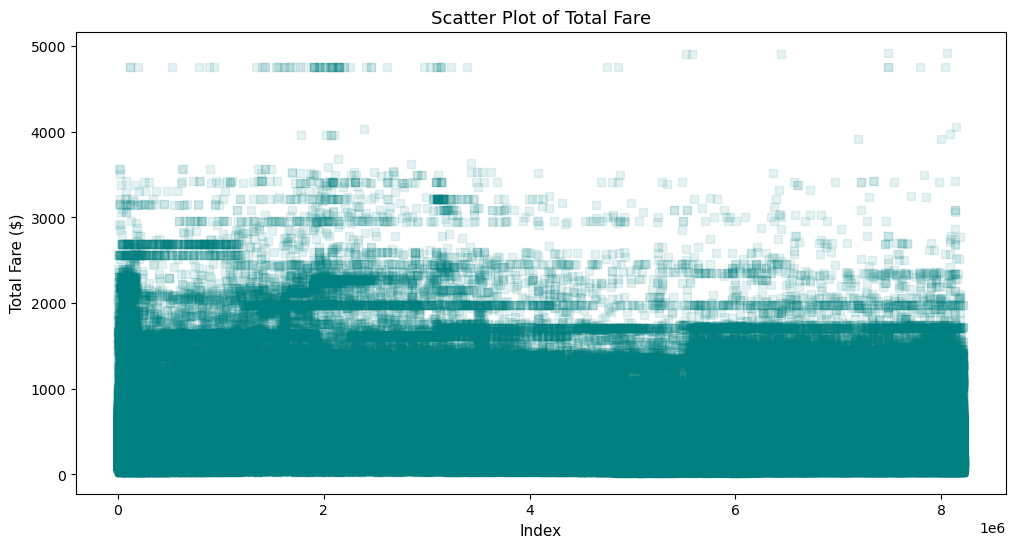

In [40]:
#fig, ax = plt.subplots(figsize=(12,6))
#ax.scatter(x=sample_flight_data.index, y=sample_flight_data['totalFare'], marker='s', color='teal', alpha=0.1)

#ax.set_xlabel('Index', fontsize=11)
#ax.set_ylabel('Total Fare ($)', fontsize=11)
#ax.set_title('Scatter Plot of Total Fare', fontsize=13)
#ax.ticklabel_format(style='plain', axis='y', useLocale=True)

#plt.show()

Checking for null values in the **sample_flight_data**:

In [43]:
sample_flight_data.select([F.count(F.when(F.col(c).isNull(), c)).alias(c) for c in sample_flight_data.columns]).toPandas().transpose()

,0
flightDate,0
startingAirport,0
destinationAirport,0
isBasicEconomy,0
isRefundable,0
isNonStop,0
baseFare,0
totalFare,0
seatsRemaining,0
totalTravelDistance,610293


## EDA (Exploratory Data Analysis)

**Q1. What is the average fare by each month?**

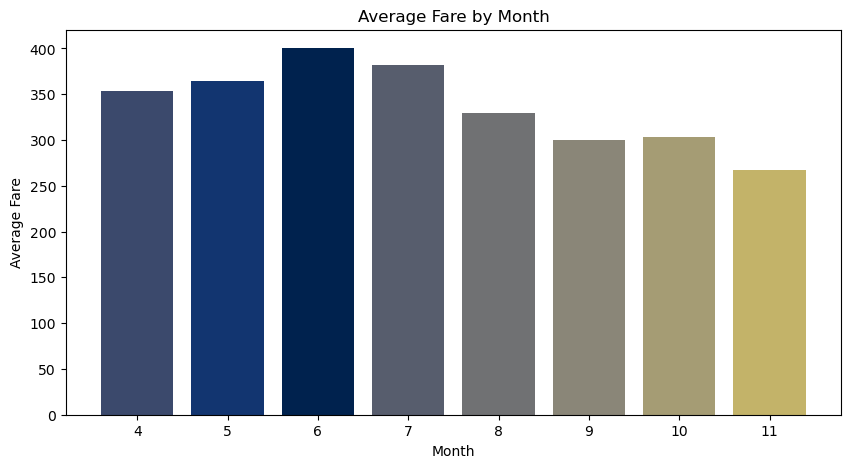

In [45]:
sample_flight_data = sample_flight_data.withColumn('month', month('flightDate'))
averageFare = sample_flight_data.groupBy('month').agg(avg('totalFare').alias('averageFare'))
averageFare_pd = averageFare.toPandas()

colors_1 = ['#00224e', '#123570', '#3b496c', '#575d6d', '#707173', '#8a8678', '#a59c74', '#c3b369']
plt.figure(figsize=(10,5))

plt.bar(averageFare_pd['month'], averageFare_pd['averageFare'], color=colors_1)
plt.xlabel('Month')
plt.ylabel('Average Fare')
plt.title('Average Fare by Month')
plt.show()

As seen from the graph above, there is a trend with average fare. It initially increases from months 4 to 6 (April to June) and then decreases from months 7 to 11 (July to November). April to June are the summer months therefore one possible reason for higher fares could be high demand from people traveling for vacations. Subsequently, from august to december the demand for vacation traveling is lower which could be the reason for lower fares. 

**Q2. What is the average fare by each airline?**

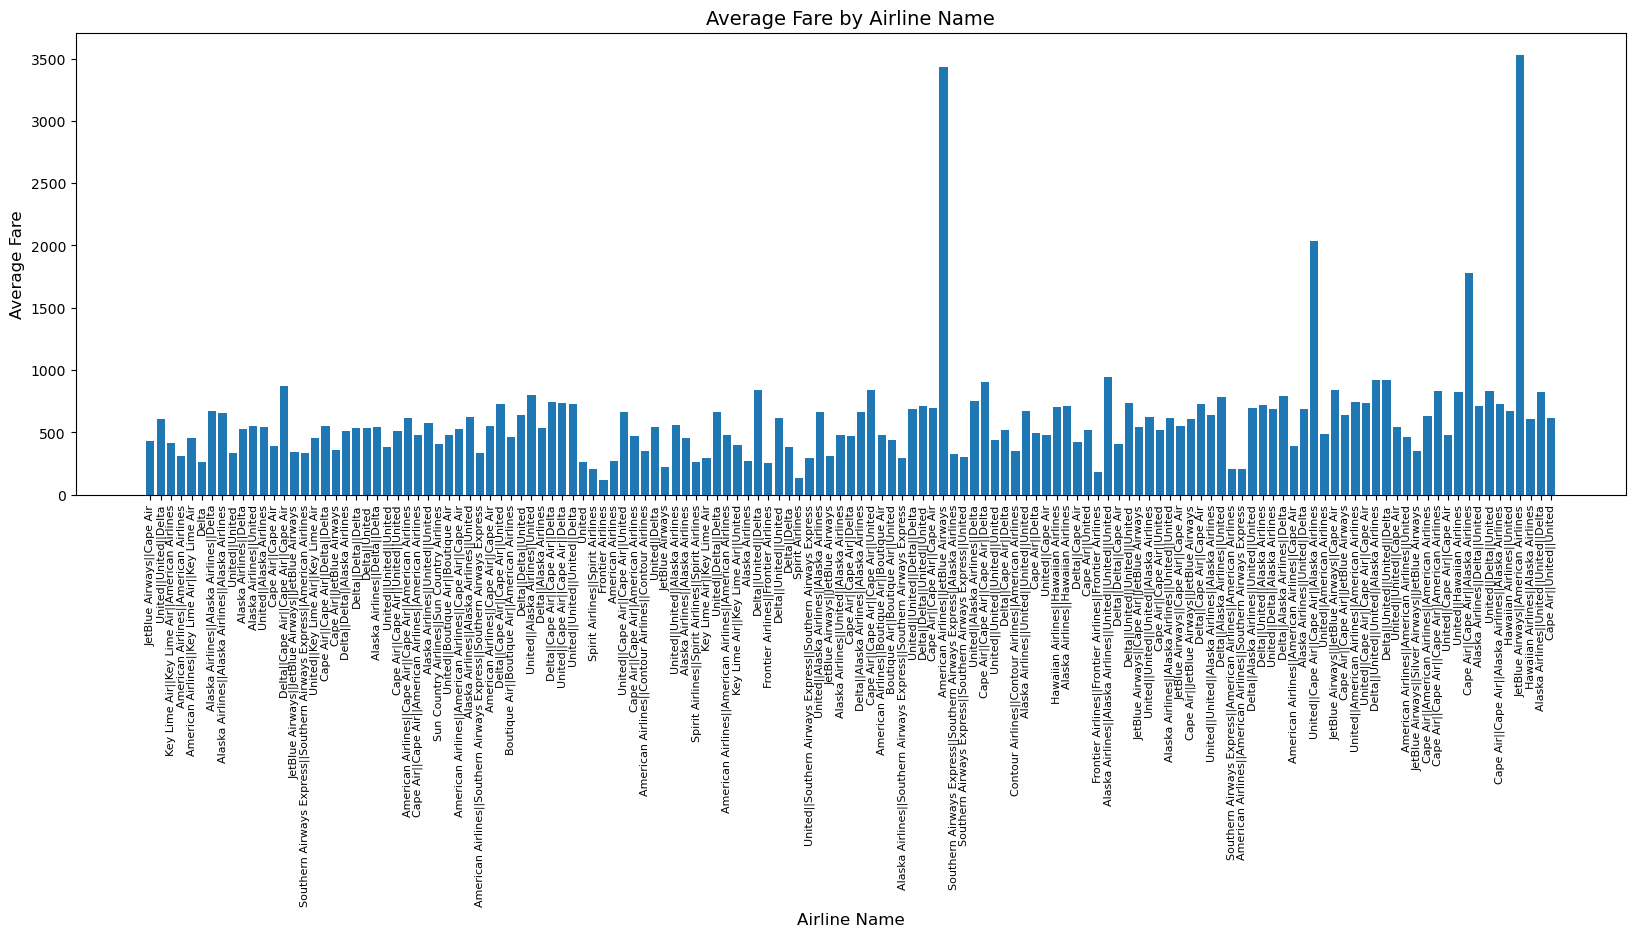

In [48]:
averageFare_byFlight = sample_flight_data.groupBy('airline_name').agg(avg('totalFare').alias('averageFare'))
averageFare_byFlight_pd = averageFare_byFlight.toPandas()

fig, ax = plt.subplots(figsize=(20, 6))

ax.bar(averageFare_byFlight_pd['airline_name'], averageFare_byFlight_pd['averageFare'])
ax.set_xlabel('Airline Name', fontsize=12)
ax.set_ylabel('Average Fare', fontsize=12)
ax.set_title('Average Fare by Airline Name', fontsize=14)
plt.xticks(rotation=90, fontsize= 8)

plt.show()

The graph above shows that often airlines work together and are part of groups for e.g. Star Alliance. Hence we get unique combinations of different airlines. Going forward, we would need to do more research and gain some domain knowledge about collaborations in the airline industry. Then we can feature engineer to see the impact of a single airline company on fare. 

**Q3. What are the 10 most popular routes?**

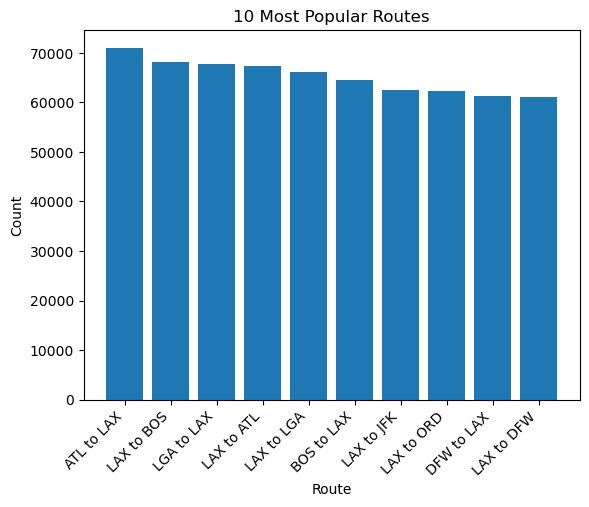

In [49]:
popularRoutes = sample_flight_data.groupBy(col('startingAirport'), col('destinationAirport')).count()
popularRoutes_top10 = popularRoutes.orderBy(col('count').desc()).limit(10)
popularRoutes_top10_pd = popularRoutes_top10.toPandas()

plt.bar(popularRoutes_top10_pd['startingAirport'] + ' to ' + popularRoutes_top10_pd['destinationAirport'], popularRoutes_top10_pd['count'])
plt.xlabel('Route')
plt.ylabel('Count')
plt.title('10 Most Popular Routes')
plt.xticks(rotation=45, ha='right')

plt.show()

LAX (Los Angeles airport) seems to be one of the most popular. We can observe from the plot above that 10 most popular routes are either from or to LAX.

**Q4. What are the 10 least popular routes?**

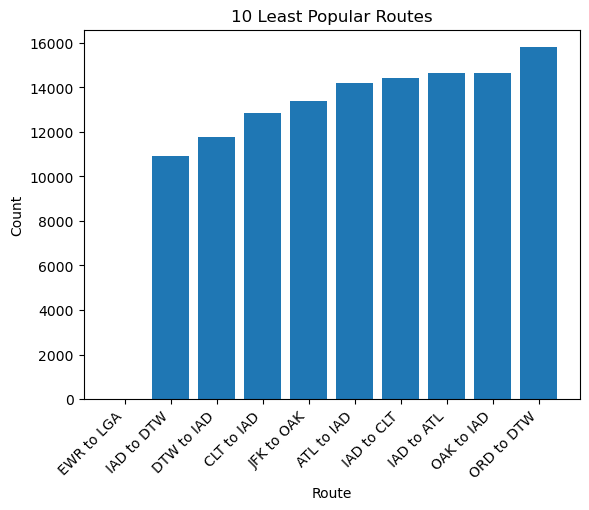

In [50]:
leastPopularRoutes = popularRoutes.orderBy(col('count')).limit(10)
leastPopularRoutes_pd = leastPopularRoutes.toPandas()

plt.bar(leastPopularRoutes_pd['startingAirport'] + ' to ' + leastPopularRoutes_pd['destinationAirport'], leastPopularRoutes_pd['count'])
plt.xlabel('Route')
plt.ylabel('Count')
plt.title('10 Least Popular Routes')
plt.xticks(rotation=45, ha='right')

plt.show()

In contrast to the 10 most popular routes, where LAX was the most popular airport, we do not see a singular least popular airport but combinations. One possible indicator for less popular routes could be the population of the city and its economic activities. 

**Q5: Which dates have the most or least flights?**

In [51]:
tickets_by_date = sample_flight_data.groupBy('flightDate').agg(count('*').alias('num_tickets')).orderBy('flightDate', ascending=True)
tickets_bydayofweek = sample_flight_data.groupBy('flight_week_day').agg(count('*').alias('num_tickets')).orderBy('num_tickets', ascending=True)


# Dates with the most flights
most_tickets_dates = tickets_by_date.orderBy('num_tickets', ascending=False).limit(10)
most_tickets_dates.show()

+----------+-----------+
|flightDate|num_tickets|
+----------+-----------+
|2022-08-30|      72994|
|2022-09-07|      69500|
|2022-09-13|      68967|
|2022-08-23|      66809|
|2022-09-08|      66726|
|2022-08-31|      66520|
|2022-08-24|      65916|
|2022-09-20|      65594|
|2022-08-29|      65574|
|2022-09-14|      64060|
+----------+-----------+



In [52]:
# Dates with the least flights
least_tickets_dates = tickets_by_date.orderBy('num_tickets', ascending=True).limit(10)
least_tickets_dates.show()


+----------+-----------+
|flightDate|num_tickets|
+----------+-----------+
|2022-04-17|        824|
|2022-04-18|       1649|
|2022-11-19|       2195|
|2022-04-19|       3100|
|2022-11-18|       3571|
|2022-04-20|       4125|
|2022-04-21|       4460|
|2022-11-17|       4795|
|2022-04-24|       5128|
|2022-04-23|       5302|
+----------+-----------+



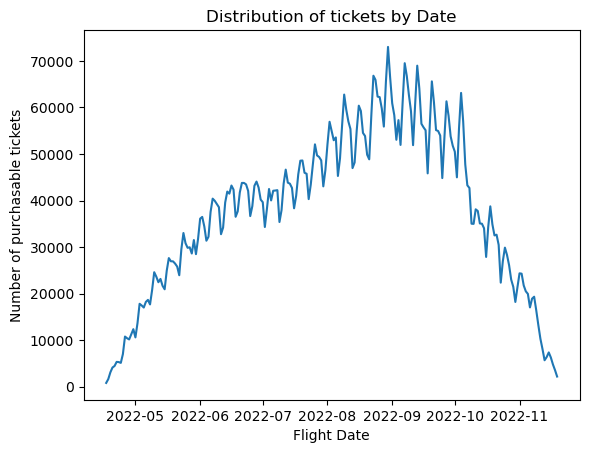

In [53]:
tickets_by_date_pd = tickets_by_date.toPandas()

plt.plot(tickets_by_date_pd['flightDate'], tickets_by_date_pd['num_tickets'])
plt.xlabel('Flight Date')
plt.ylabel('Number of purchasable tickets')
plt.title('Distribution of tickets by Date')

plt.show()

The date with the highest number of flight tickets was on August 30, 2022, while the date with the lowest number of flight tickets was on April 17, 2022. One possible explanation for the low number of  flight tickets on April 17th is that it coincided with a rare intersection of major holidays of Easter, Passover, and Ramada for Christians, Jews, and Muslims, which only occurs every 30 years.

The line chart shows that the number of flight tickets follows a cyclic pattern on a weekly basis. Further analysis of the data by day of the week suggests that the reason for this pattern is that weekdays tend to have more number of flight tickets than weekends.

**Q6: Which day of the week has the highest number of flights?**

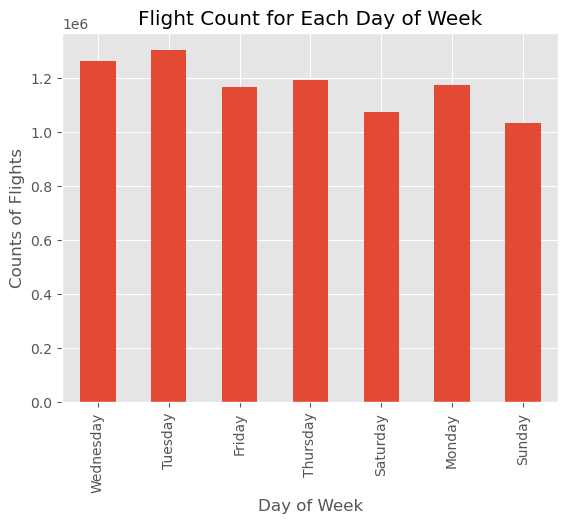

In [54]:
week_day = sample_flight_data.groupBy('flight_week_day').agg(count('*').alias('num_flights'))

py_week_day = week_day.toPandas()
df_week_day = py_week_day.set_index('flight_week_day')
plt.style.use('ggplot')
df_week_day['num_flights'].plot(kind='bar')
plt.title('Flight Count for Each Day of Week')
plt.ylabel('Counts of Flights')
plt.xlabel('Day of Week')

plt.show()

**Q7. Which airline has the highest fare?** 

In [61]:
airline_counts = sample_flight_data.groupBy('airline_name').agg(count('*').alias('count'))
airline_counts.show()

+--------------------+-------+
|        airline_name|  count|
+--------------------+-------+
|JetBlue Airways||...|    130|
|United||United||D...| 123347|
|Key Lime Air||Key...|    872|
|American Airlines...|1629196|
|American Airlines...|   1782|
|               Delta| 485898|
|Alaska Airlines||...|  15643|
|Alaska Airlines||...|  12883|
|      United||United|1022524|
|Alaska Airlines||...|  30690|
|Alaska Airlines||...|  48712|
|Southern Airways ...|     80|
|United||Alaska Ai...|  45159|
|  Cape Air||Cape Air|    982|
|JetBlue Airways||...|  10948|
|Southern Airways ...|   4299|
|United||Key Lime ...|   1013|
|Cape Air||Cape Ai...|    801|
|Cape Air||JetBlue...|    190|
|Delta||Delta||Ala...|  13724|
+--------------------+-------+
only showing top 20 rows



In [ ]:
sample_2 = sample_flight_data.toPandas()

sns.catplot(y="totalFare", x="airline_name", data=pdf.sort_values("totalFare", ascending=False), kind="boxen", height=6, aspect=3)

plt.show()

From graph we can see that Jet Airways Business have the highest Price.